# Heart rate estimation from ECG signal

## Introduction
The heart is one of the body's most essential organs. Some heart diseases can-be life threatening. That is why we need to detect them before irreversible repercussions take place. By monitoring the electrical activity of our body from the outside, we can see what happens inside of it. We're in luck since we can actually measure the impact of the heart's activity by pacing electrodes on the skin. This procedure is called an Electrocardiography and we obtain a electrocardiogram (ECG or EKG). In the following, we will be analyzing an electrocardiogram signal to estimate the heart rate.

In [1]:
# Import statements
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import pandas as pd
import scipy as sp
from scipy.signal import find_peaks, butter, filtfilt


# Loading ecg
from scipy.misc import electrocardiogram
# You can also access it on https://physionet.org/

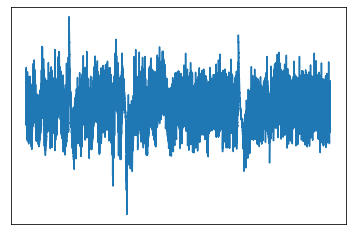

In [2]:
# Example of an ecg signal
ecg_whole = electrocardiogram()
plt.plot(ecg_whole)
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

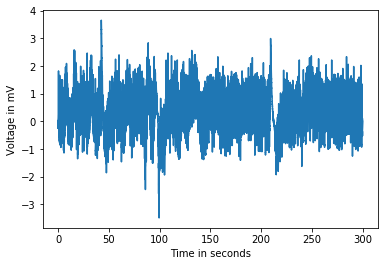

In [3]:
fs = 360 # sampling frequency in Hz

timestamps = np.arange(len(ecg_whole))*1/fs
plt.plot(timestamps, ecg_whole)
plt.xlabel('Time in seconds')
plt.ylabel('Voltage in mV');

In [4]:
print("Total signal length: {} minutes".format(np.round(timestamps[-1]/60)))

Total signal length: 5.0 minutes


In [5]:
# We can trim the signal and use only the first part for the next steps
ecg = ecg_whole[0:1000]

## Heart Physiology
### Origin of the ECG signal 

The heart is made up of four chambers: the left and right atria and the left and right ventricles. The cardiac myocytes that form the heart are electrically excitable. As we all know, the heart pump blood throughout the body to deliver oxygen and nutrients to the tissues and evacuate waste and toxins. This happens in response to electrical excitation. The heart beats in a regular rhythm and is controlled by the electrical conduction system which is composed of specialized cardiac myocytes, called pacemakers. The sinus node causes the atria to contract. The AV node then causes the ventricles to contract.   

The membrane of a cell has channels which open and close according to the voltage. They allow ions to go across the membrane.
When an electrical excitation arrives, it propagates through the rest of the membrane and changes the ion concentration. At rest, the interior of the cell is positively charged relative to the outside.   
The ECG wave results from the movement of ions across the membrane of the cardiac myocytes and can be measured using electrodes on the skin.

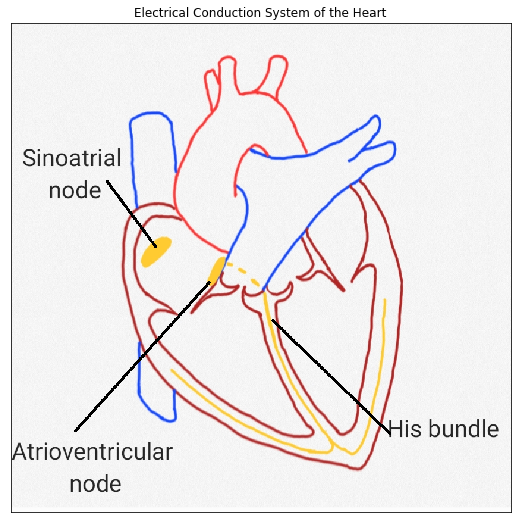

In [6]:
img = plt.imread("data\heart.png") # Own work
plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.title("Electrical Conduction System of the Heart")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

### QRS complex

The repeating pattern is the P wave followed by the QRS complex and the T wave.

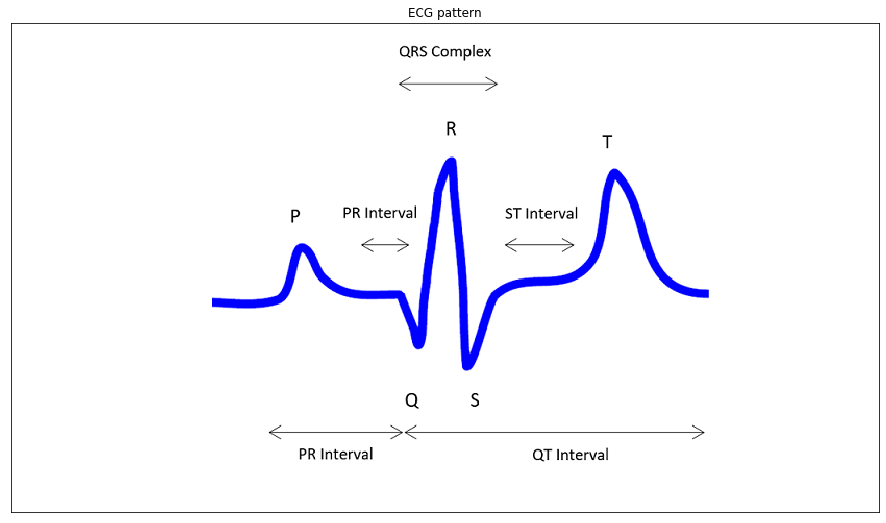

In [7]:
img = plt.imread("data\pattern-ecg.png") # Own work
plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.title("ECG pattern")
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

Let's try to visualize a QRS complex in the signal we have.

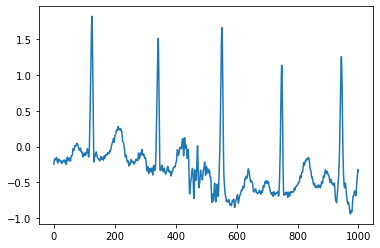

In [8]:
plt.plot(ecg);

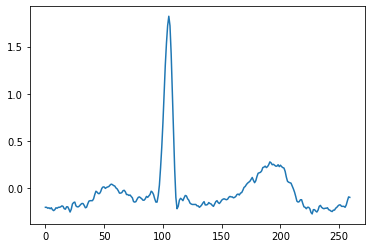

In [9]:
plt.plot(ecg[20:280]);

We can see that noise can alter our signal and change its appearance.

## Heart rate estimation

### Simple peak detection
We can use the signal in the time domain and detect the R peaks since they have the larger magnitude.

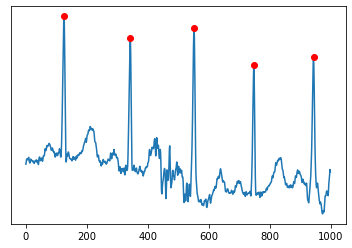

In [10]:
r_peaks, _ = find_peaks(ecg, distance = 150)
plt.plot(ecg)
plt.plot(r_peaks, ecg[r_peaks], 'ro')
plt.gca().axes.yaxis.set_visible(False)

In [11]:
print('Average heart rate {:.0f} bpm'.format(np.mean(60/np.diff(r_peaks/fs))))

Average heart rate 106 bpm


>  A normal resting heart rate should be between 60 and 100 beats per minute, which means we are not far off.

Let's use the whole signal to do the same estimation.

In [12]:
r_peaks, _ = find_peaks(ecg_whole, distance = 150)
print('Average heart rate {:.0f} bpm'.format(np.mean(60/np.diff(r_peaks/fs))))

Average heart rate 106 bpm


Having the same result doesn't mean we have a perfect method for heart rate estimation. It might be that our signal was acquired in very good conditions. But, it could also mean that an error compensates another. Let's visualize random windows of our signal to see how our algorithm is doing.

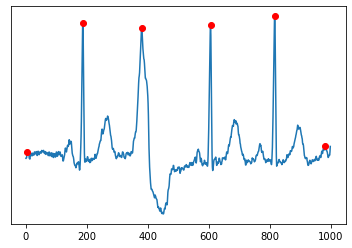

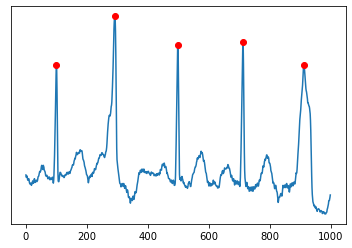

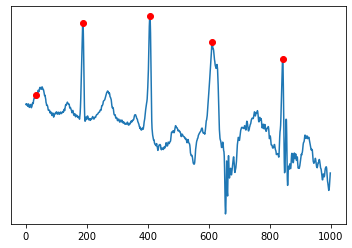

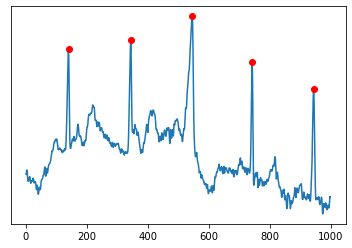

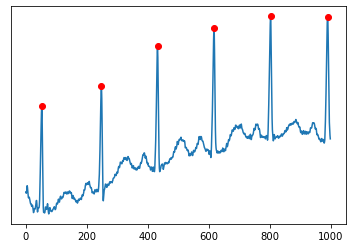

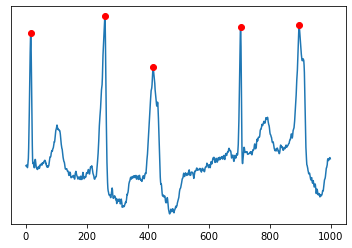

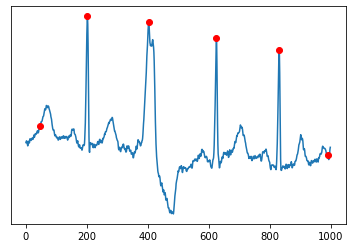

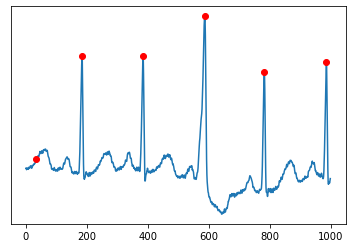

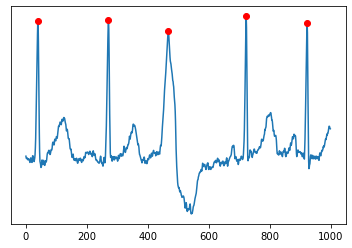

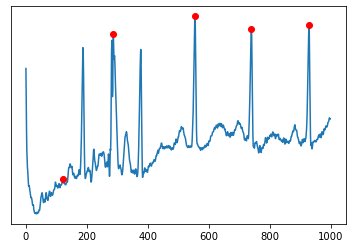

In [13]:
for counter in range(10):
    length = 1000
    start = np.random.randint(len(ecg_whole)-length)
    r_peaks, _ = find_peaks(ecg_whole[start:start+length], distance = 150)
    plt.plot(ecg_whole[start:start+length])
    plt.plot(r_peaks, ecg_whole[start:start+length][r_peaks], 'ro')
    plt.gca().axes.yaxis.set_visible(False)
    plt.show()

Our estimation method is not robust to noise. That is why we will use the Pan-Tompkins algorithm.

### Pan-Tompkins algorithm

The purpose of the Pan-Tompkins algorithm is to detect QRS complexes and locate heartbeats. To do that, we need to improve the signal-to-noise ratio (SNR). We start by using a bandpass filter to remove noise.

We can look at the frequency components of our signal. We will do that by performing a Fast Fourier Transform (FFT).

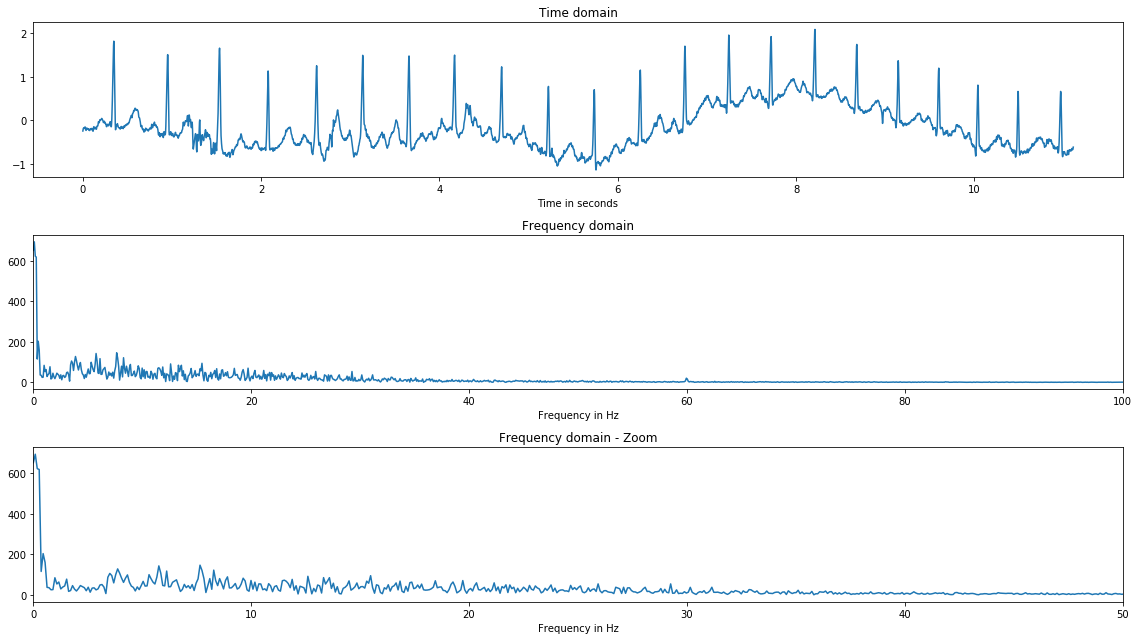

In [14]:
ecg = ecg_whole[:4000]
timestamps = np.arange(len(ecg))*1/fs
freqs = fft.rfftfreq(len(ecg), 1/fs)
fft = fft.rfft(ecg)

plt.figure(figsize=(16, 9))

# Plotting signal in time domain
plt.subplot(3,1,1)
plt.plot(timestamps, ecg)
plt.title('Time domain')
plt.xlabel('Time in seconds')

# Plotting signal in time domain
plt.subplot(3,1,2)
plt.plot(freqs, np.abs(fft))
plt.title('Frequency domain')
plt.xlabel('Frequency in Hz')
plt.xlim([0, 100])
plt.tight_layout()
plt.subplot(3,1,3)
plt.plot(freqs, np.abs(fft))
plt.title('Frequency domain - Zoom')
plt.xlabel('Frequency in Hz')
plt.xlim([0, 50])
plt.tight_layout()

> The signal is made up of lower frequencies. We notice a peak at 60 Hz which correspond to the power grid in North America (in Europe it is 50 Hz).

We choose a bandpass filter between 4 and 15 Hz. Afterwards, we want to attenuate the P-wave and T-wave and we can do that by derivation. The QRS complex has a sharper variation. Then, we apply an element-wise squaring operation. Finally, we perform a moving sum to account for the time needed for a pacemaker cell to return to its initial state which is about 150 milliseconds. To find the positions of the R peaks, we can do simple peak detection.

In [15]:
def bpfilter(signal):
    """Bandpass filter the signal between 5 and 15 Hz"""
    b, a = butter(3, (4, 15), btype='bandpass', fs=fs)
    return filtfilt(b, a, signal)

def movingsum(signal):
    """Moving sum with a window size of 150ms"""
    n_samples = int(round(fs * 0.150))
    processed_signal = pd.Series(pd.Series(signal).rolling(n_samples, center=True).sum().fillna(0)).values
    return processed_signal

def detectpeaks(signal):
    """Select the QRS complexes"""
    thresh = np.mean(signal)
    peaks, _ = find_peaks(signal, height=thresh, width=10)
    return peaks

def PanTompkins(signal):
    """Pan-Tompkins algorithm"""
    processed_signal = movingsum(np.square(np.diff(bpfilter(signal), append=0)))  
    peaks = detectpeaks(processed_signal)
    return peaks, processed_signal

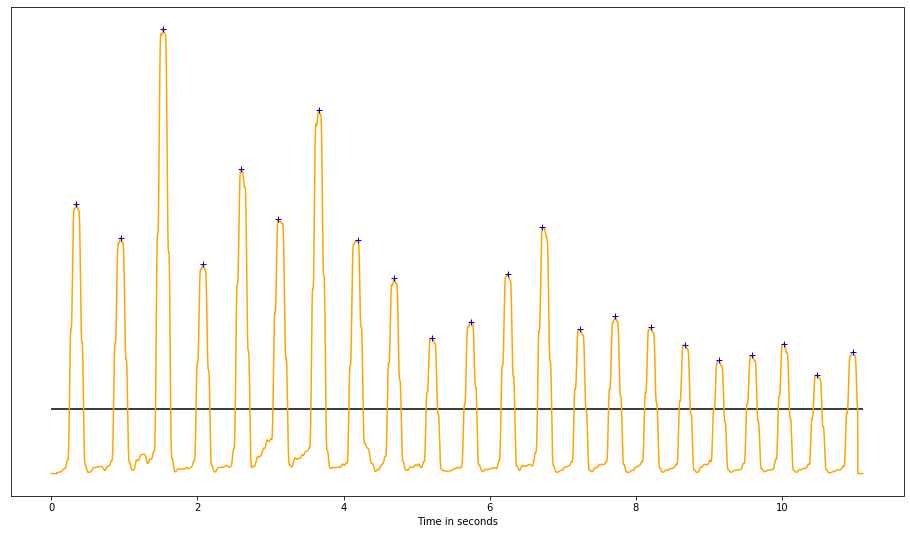

In [16]:
# Let's plot the signal after processing
peaks, processed_signal = PanTompkins(ecg)
plt.figure(figsize=(16, 9))
plt.plot(timestamps, processed_signal, color='orange')
plt.plot(timestamps[peaks], processed_signal[peaks], 'b+')
plt.hlines(processed_signal.mean(), timestamps[0], timestamps[-1], 'k')
plt.xlabel('Time in seconds')
plt.gca().axes.yaxis.set_visible(False)

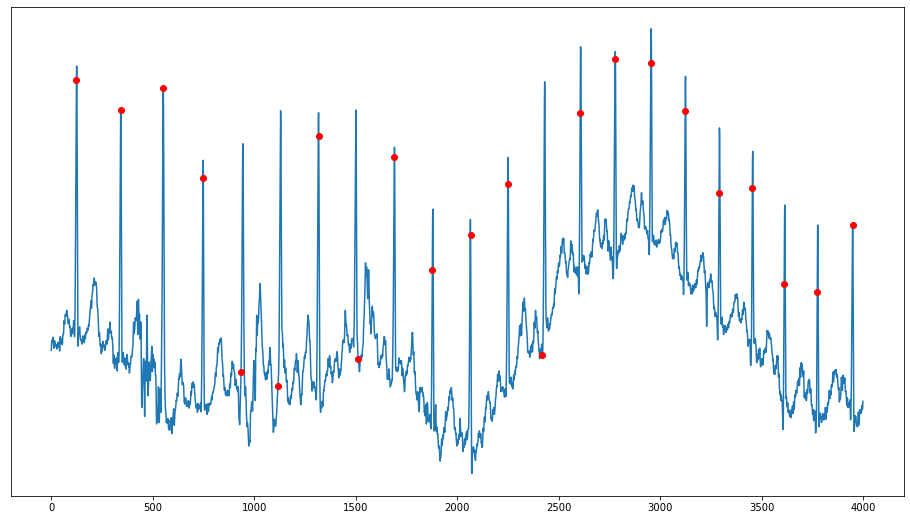

In [17]:
# Let's visualize the result of the Pan-Tompkins algorithm
plt.figure(figsize=(16, 9))
plt.plot(ecg)
pt_peaks, _ = PanTompkins(ecg)
plt.plot(pt_peaks, ecg[pt_peaks], 'ro')
plt.gca().axes.yaxis.set_visible(False)

> We improved our algorithm in terms of robustness to noise. We could also impose a distance between peaks in order to further improve its performance.

## Next steps

To find evidence of a cardiovascular disease in an ECG, the first step is finding the QRS complexes. Then, you would have to see if the P-wave and T-wave also occur.

In Atrial Fibrillation, there is no coherent contraction of the atria. In this case, there are no P-waves in the ECG and we get an irregular heart rhythm.

The average heart rate wouldn't tell us if a patient has an irregular heart rhythm. If we want to build a classifier to tell us if the person has arrhythmia, we will need to extract other features from our original signal such as the RR interval.

## References
[1](https://ieeexplore.ieee.org/abstract/document/7019490) L. Sathyapriya, L. Murali and T. Manigandan, "Analysis and detection R-peak detection using Modified Pan-Tompkins algorithm," 2014 IEEE International Conference on Advanced Communications, Control and Computing Technologies, Ramanathapuram, India, 2014, pp. 483-487, doi: 10.1109/ICACCCT.2014.7019490.    
[2](https://www.coursera.org/learn/physiology) Introductory Human Physiology, Duke University, Coursera.